<a href="https://colab.research.google.com/github/thaitruong018/e_commerce_analysis/blob/main/4_Customer_Segmentation_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is Customer segmentation?  
Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.  
In business to customer marketing, companies often segment customers according to demographics that include:  
* Age
* Gender  
* Marital status  
* Location (urban, suburban, rural)


## Set-up

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# install pywaffle
!pip install pywaffle

     |████████████████████████████████| 526 kB 8.2 MB/s 


In [ ]:
# import libraries
import pandas as pd
import os, re
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pywaffle import Waffle
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
# define a func to plit waffle chart
def plot_waffle_chart_(df, metric, agg, title_, group='sub_segment'):
  dict_revenue = dict(round(df.groupby(group).agg({metric:agg}),0)[metric])
  plt.figure( FigureClass=Waffle, rows = 5, columns =10, values = dict_revenue,
             labels =[(x,y) for x,y in dict_revenue.items()], 
             legend ={'loc':'lower left', 'bbox_to_anchor':(1,0)},
             figsize= (15,5)
             )
  plt.title(title_)
# define a funtion to convert datatype
def convert_to_dt(df, cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col], format= '%Y-%m-%d').dt.date

In [ ]:
# path to data
path = '/content/gdrive/MyDrive/brazilian_ecommerce'

## Data

In [ ]:
# read data
df_orders = pd.read_csv(os.path.join(path,'df_order_items_products_customers.csv'))
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,quantity,seller_id,shipping_limit_date,price,freight_value,product_category_name,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,moveis_decoracao,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR
1,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,f293394c72c9b5fafd7023301fc21fc2,1,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,moveis_decoracao,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR
2,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-14 02:44:30,39.99,22.34,moveis_decoracao,f922896769e9517ea3c630f3c8de86d0,96832,santa cruz do sul,RS
3,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-26 16:35:46,39.99,11.80,moveis_decoracao,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG
4,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,c1488892604e4ba5cff5b4eb4d595400,2,1554a68530182680ad5c8b042c3ab563,2017-01-13 00:37:18,38.50,15.56,moveis_decoracao,853ba75a0b423722ccf270eea3b4cfe4,21843,rio de janeiro,RJ


In [ ]:
# overall info
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       102425 non-null  object 
 1   customer_id                    102425 non-null  object 
 2   order_status                   102425 non-null  object 
 3   order_purchase_timestamp       102425 non-null  object 
 4   order_approved_at              102425 non-null  object 
 5   order_delivered_carrier_date   102425 non-null  object 
 6   order_delivered_customer_date  102425 non-null  object 
 7   order_estimated_delivery_date  102425 non-null  object 
 8   product_id                     102425 non-null  object 
 9   quantity                       102425 non-null  int64  
 10  seller_id                      102425 non-null  object 
 11  shipping_limit_date            102425 non-null  object 
 12  price                         

In [ ]:
# converting date
cols = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
                       'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date' ]
convert_to_dt(df_orders, cols)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,quantity,seller_id,shipping_limit_date,price,freight_value,product_category_name,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-26,39.99,31.67,moveis_decoracao,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR
1,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,f293394c72c9b5fafd7023301fc21fc2,1,1554a68530182680ad5c8b042c3ab563,2016-10-26,32.90,31.67,moveis_decoracao,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR
2,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-14,39.99,22.34,moveis_decoracao,f922896769e9517ea3c630f3c8de86d0,96832,santa cruz do sul,RS
3,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-26,39.99,11.80,moveis_decoracao,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG
4,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,c1488892604e4ba5cff5b4eb4d595400,2,1554a68530182680ad5c8b042c3ab563,2017-01-13,38.50,15.56,moveis_decoracao,853ba75a0b423722ccf270eea3b4cfe4,21843,rio de janeiro,RJ


In [ ]:
# define a sub-dataframe
df_segment = df_orders[['customer_unique_id','order_id','order_status','order_purchase_timestamp',
    'product_id','quantity','price','product_category_name']].copy()
df_segment.head()

,customer_unique_id,order_id,order_status,order_purchase_timestamp,product_id,quantity,price,product_category_name
0,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,1,39.99,moveis_decoracao
1,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04,f293394c72c9b5fafd7023301fc21fc2,1,32.90,moveis_decoracao
2,f922896769e9517ea3c630f3c8de86d0,35d3a51724a47ef1d0b89911e39cc4ff,delivered,2016-10-04,c1488892604e4ba5cff5b4eb4d595400,1,39.99,moveis_decoracao
3,0ecf7f65b5ff3b9e61b637e59f495e0a,c4f710df20f7d1500da1aef81a993f65,delivered,2016-10-10,c1488892604e4ba5cff5b4eb4d595400,1,39.99,moveis_decoracao
4,853ba75a0b423722ccf270eea3b4cfe4,81e5043198a44ddeb226002ff55d8ad4,delivered,2017-01-09,c1488892604e4ba5cff5b4eb4d595400,2,38.50,moveis_decoracao


In [ ]:
# check how many status
df_segment['order_status'].value_counts()

delivered      100196
shipped          1127
canceled          465
invoiced          322
processing        306
unavailable         7
approved            2
Name: order_status, dtype: int64

In [ ]:
# using only delivered status
df_segment = df_segment[df_segment['order_status']=='delivered']

In [ ]:
# calculate the total price for an order line
df_segment['total_payment'] = df_segment['quantity'] * df_segment['price']

## Customer segmentation

### segmentation based on recency and payment

In [ ]:
# last day of dataset
df_segment['order_purchase_timestamp'].max()

datetime.date(2018, 8, 29)

In [ ]:
# assume now is 30/08
now = dt.date(2018, 8, 30)
# calculate recency, frequency, monetary
df_segmented_customers = df_segment.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda date:(now-date.max()).days,
                                                                       'order_id':pd.Series.nunique,
                                                                       'total_payment': ['sum','mean'],
                                                                       'quantity':'sum'}).reset_index()  
# renaming columns
df_segmented_customers.columns = ['customer_unique_id','recency','frequency','total_payment','avg_payment','quantity']
df_segmented_customers.head()

,customer_unique_id,recency,frequency,total_payment,avg_payment,quantity
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,18.90,1
2,0000f46a3911fa3c0805444483337064,538,1,69.00,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,180.00,1


In [ ]:
# Defining time range conditions for classifying customers
total_time_range = str(df_segment["order_purchase_timestamp"].max() - df_segment["order_purchase_timestamp"].min())
total_time_range

'713 days, 0:00:00'

In [ ]:
# Splitting total time range in 4 time periods
period = int(re.sub(r'\s+days.*', '', total_time_range))/4
period

178.25

In [ ]:
# activity classes
class_inactive = df_segmented_customers['recency'] > period*3
class_cold = (df_segmented_customers['recency'] > period*2)&(df_segmented_customers['recency']<=period*3)
class_hot = (df_segmented_customers['recency'] > period)&(df_segmented_customers['recency']<=period*2)
class_active = df_segmented_customers['recency'] <= period
# add new columns
# customers who did not make any purchases or their last purchase was more than three times of the period defined as a parameter
df_segmented_customers.loc[class_inactive, "segment"]= "inactive" 
# customers that their last purchase was greater than twice period and less than or equal to the three times the period
df_segmented_customers.loc[class_cold, 'segment'] = 'cold'
# customers that their last purchase was greater than the period and less than or equal to the twice period
df_segmented_customers.loc[class_hot,'segment'] = 'hot'
# customers that their last purchase was less than or equal to the period
df_segmented_customers.loc[class_active, 'segment'] = 'active'

df_segmented_customers.head()


,customer_unique_id,recency,frequency,total_payment,avg_payment,quantity,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,129.90,1,active
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,18.90,1,active
2,0000f46a3911fa3c0805444483337064,538,1,69.00,69.00,1,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,25.99,1,hot
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,180.00,1,hot


In [ ]:
# define payment range conditions for classifying customers
median_payment = df_segmented_customers['avg_payment'].median()
median_payment

84.5

In [ ]:
# sub classes
class_inactive_low = df_segmented_customers['segment'] =='inactive'
class_cold_low = (df_segmented_customers['segment']=='cold') &(df_segmented_customers['avg_payment']<median_payment)
class_cold_high = (df_segmented_customers['segment']=='cold') &(df_segmented_customers['avg_payment']>=median_payment)

class_hot_low = (df_segmented_customers['segment'] == 'hot') & (df_segmented_customers['avg_payment'] < median_payment)
class_hot_high = (df_segmented_customers['segment'] == 'hot') & (df_segmented_customers['avg_payment'] >= median_payment)

class_active_low = (df_segmented_customers['segment'] == 'active')& (df_segmented_customers['avg_payment'] < median_payment)
class_active_high = (df_segmented_customers['segment'] == 'active')& (df_segmented_customers['avg_payment'] >= median_payment)

# add sub classes to dataframe
# customers who did not make any purchases or their last purchase was more than three times of the period defined as a parameter
df_segmented_customers.loc[class_inactive_low, "sub_segment"] = "inactive"
# this segment is equal to cold and have purchases less than the median defined as a parameter 
df_segmented_customers.loc[class_cold_low, "sub_segment"] = "cold_low"
# this segment is equal to cold and have purchases greater than or equal to the median defined as a parameter
df_segmented_customers.loc[class_cold_high, "sub_segment"] = "cold_high"
# this segment is equal to hot and have purchases less than the median defined as a parameter
df_segmented_customers.loc[class_hot_low, "sub_segment"] = "hot_low"
# this segment is equal to hot and have purchases greater than or equal to the median defined as a parameter
df_segmented_customers.loc[class_hot_high, "sub_segment"] = "hot_high"
# this segment is equal to active and have purchases less than the median defined as a parameter
df_segmented_customers.loc[class_active_low, "sub_segment"] = "active_low"
# this segment is equal to active and have purchases greater than or equal to the median defined as a parameter
df_segmented_customers.loc[class_active_high, "sub_segment"] = "active_high"

df_segmented_customers.head()

,customer_unique_id,recency,frequency,total_payment,avg_payment,quantity,segment,sub_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,129.90,1,active,active_high
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,18.90,1,active,active_low
2,0000f46a3911fa3c0805444483337064,538,1,69.00,69.00,1,inactive,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,25.99,1,hot,hot_low
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,180.00,1,hot,hot_high


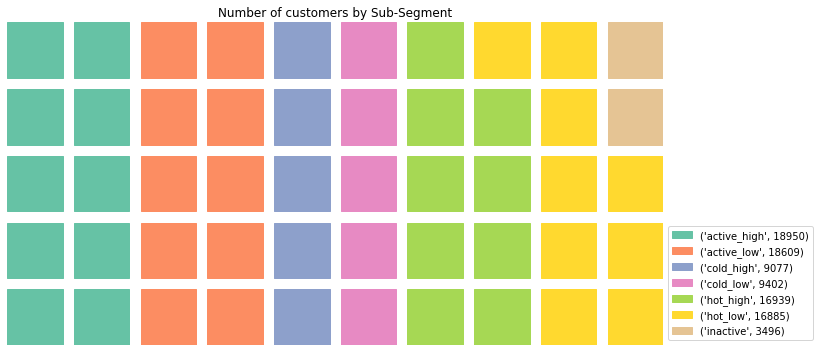

In [ ]:
# number of customers per sub-segment
plot_waffle_chart_(df_segmented_customers,'customer_unique_id', 'count', 'Number of customers by Sub-Segment')

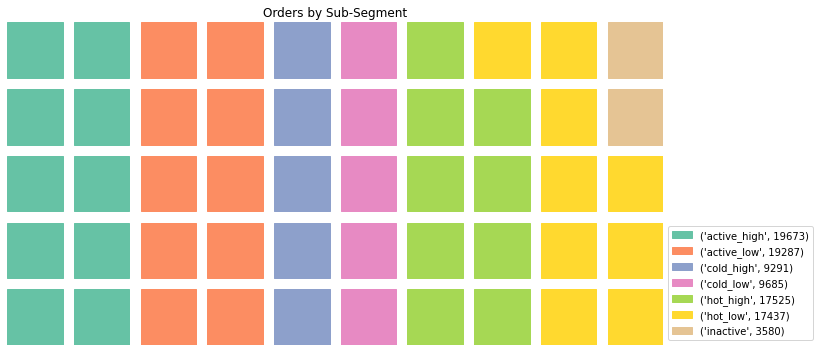

In [ ]:
# total orders placed by sub-segment
plot_waffle_chart_(df_segmented_customers, 'frequency', 'sum', 'Orders by Sub-Segment')

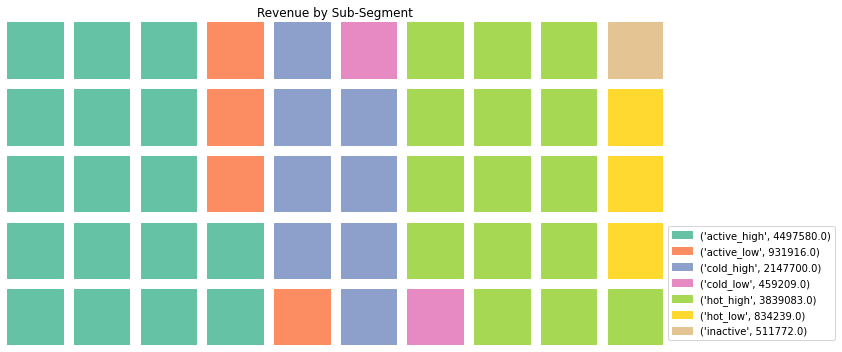

In [ ]:
# total revenue by sub-segment
plot_waffle_chart_(df_segmented_customers, 'total_payment', 'sum', 'Revenue by Sub-Segment')

From the graph we can see that:
* The strongest class of the 7 generated sub-segments is active customers with high spending, followed by hot customers which high spending, which is a good sign for the business.  
* Active customers are the biggest groups
* Active customers with high and low spending placed the most orders, followed by hot customers
* Inactive customers accounted for only a small proportion.

In [ ]:
# save file
df_segmented_customers.to_csv(os.path.join(path,'df_segmented_customers.csv'), encoding='utf-8-sig',index=False)

### RFM

RFM analysis is a customer segmentation technique that use past purchase behaviour to segment customers.  
The name RFM stands for Recency, Frequency, and Monetary value. 
* Recency: the number of days since the customer's last purchase  
* Frequency: the number of times the customer has purchased in the timeframe being analyzed  
* Monetary: the total amount spent by the customer in the same period

In [ ]:
# read data
df_rfm = pd.read_csv(os.path.join(path,'df_segmented_customers.csv'))
df_rfm.head()

,customer_unique_id,recency,frequency,total_payment,avg_payment,quantity,segment,sub_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,129.90,1,active,active_high
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,18.90,1,active,active_low
2,0000f46a3911fa3c0805444483337064,538,1,69.00,69.00,1,inactive,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,25.99,1,hot,hot_low
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,180.00,1,hot,hot_high


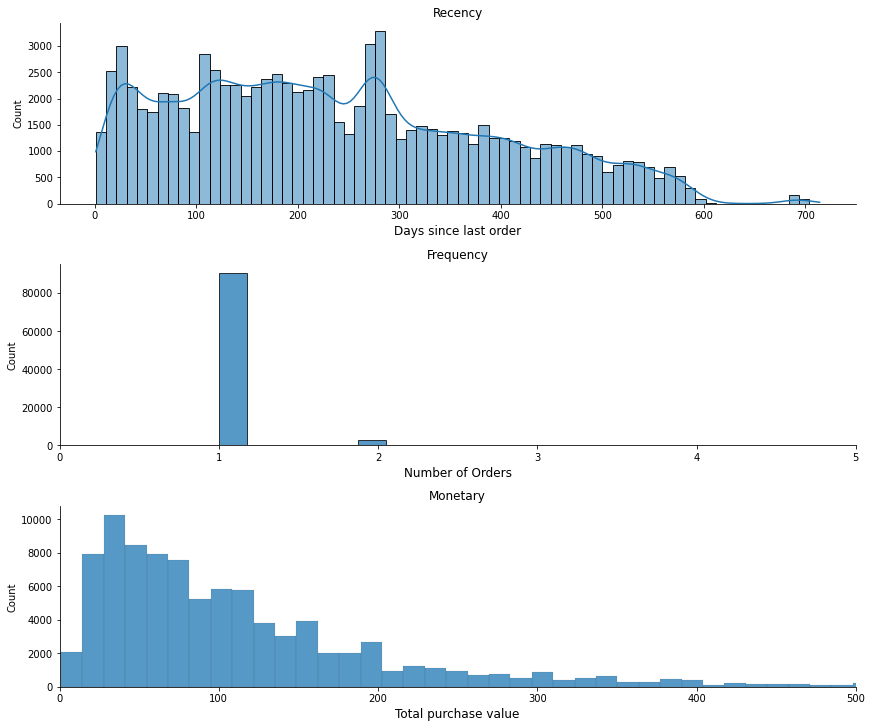

In [ ]:
# plot chart
# define figure
fig = plt.figure(constrained_layout=True, figsize=(12,10))
# define axis
gs = gridspec.GridSpec(3, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
# plot recency
sns.histplot(df_rfm['recency'], kde=True, ax = ax1)
ax1.set_title('Recency', fontsize = 12)
ax1.set_xlabel('Days since last order',fontsize= 12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# plot frequency
sns.histplot(df_rfm['frequency'], kde= False, ax = ax2, bins=80)
ax2.set_xlim([0,5])
ax2.set_title('Frequency',fontsize= 12)
ax2.set_xlabel('Number of Orders', fontsize =12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# plot monetary
sns.histplot(df_rfm['total_payment'], ax = ax3, bins=1000)
ax3.set_title('Monetary',fontsize = 12)
ax3.set_xlabel('Total purchase value', fontsize =12)
ax3.set_xlim([0,500])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.show()

From the charts above, we can see that  
* There is a peak at round about 270 days due to black friday
* There are many customers which only placed one order  
* The majority of the prices is in the lower range of up to 100


#### Calculation

In [ ]:
# frequencies:
df_rfm['frequency'].unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 15])

In [ ]:
# define a funct
def assign_frequency(x):
  if x>=7:
    return 4
  elif x>=4:
    return 3
  elif x>=2:
    return 2
  else:
    return 1


In [ ]:
# add new column
df_rfm['R'] = pd.qcut(x=df_rfm['recency'], q=4, labels=range(4,0,-1))
df_rfm['F'] = df_rfm['frequency'].apply(assign_frequency)
df_rfm['M'] = pd.qcut(x=df_rfm['total_payment'], q =4, labels = range(1,5))
# define- and assign label to dataframe
df_rfm['segment_RFM'] = df_rfm['R'].astype(str)+ df_rfm['F'].astype(str) + df_rfm['M'].astype(str)
df_rfm['score_rfm'] = df_rfm[['R','F','M']].sum(axis=1)

df_rfm

,customer_unique_id,recency,frequency,total_payment,avg_payment,quantity,segment,sub_segment,R,F,M,segment_RFM,score_rfm
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,129.90,1,active,active_high,4,1,3,413,8
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,18.90,1,active,active_low,4,1,1,411,6
2,0000f46a3911fa3c0805444483337064,538,1,69.00,69.00,1,inactive,inactive,1,1,2,112,4
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,25.99,1,hot,hot_low,2,1,1,211,4
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,180.00,1,hot,hot_high,2,1,4,214,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,1570.00,785.00,2,cold,cold_high,1,1,4,114,6
93354,fffea47cd6d3cc0a88bd621562a9d061,263,1,64.89,64.89,1,hot,hot_low,2,1,2,212,5
93355,ffff371b4d645b6ecea244b27531430a,569,1,89.90,89.90,1,inactive,inactive,1,1,3,113,5
93356,ffff5962728ec6157033ef9805bacc48,120,1,115.00,115.00,1,active,active_high,3,1,3,313,7


In [ ]:
# calculate mean by score_rfm
df_rfm.groupby('score_rfm').mean()[['recency','frequency','total_payment']]

,recency,frequency,total_payment
score_rfm,,,
3,455.415840,1.000000,28.927718
4,363.786792,1.003141,47.153606
5,297.060620,1.005762,68.964709
6,237.780465,1.012687,140.535414
7,171.463098,1.035557,176.442896
8,116.662880,1.060863,228.353614
9,67.959092,1.113117,353.635462
10,62.914286,2.161224,366.815714
11,68.238095,4.714286,861.623333


In [ ]:
# define a func
def rfm_assiner(df):
  if (int(df['segment_RFM'])>=434) or (df['score_rfm']>=9):
    return 'Best customer'
  elif (df['score_rfm'] >=8) and (df['M']==4):
    return 'Big Spender'
  elif (df['score_rfm'] >= 6) and (df['F'] >= 2):
    return 'Loyalist'
  elif (int(df['segment_RFM']) >= 231) or (df['score_rfm'] >= 6):
    return 'Potential Loyalists'
  elif ((int(df['segment_RFM']) >= 121) and (df['R'] == 1)) or df['score_rfm'] == 5:
    return 'Almost Lost'
  elif (df['score_rfm'] >= 4) and (df['R'] == 1):
    return 'Hibernating'
  else:
    return 'Lost Customer'
# add new column
df_rfm['customer_rfm_segment'] = df_rfm.apply(rfm_assiner, axis=1)
df_rfm.head()


,customer_unique_id,recency,frequency,total_payment,avg_payment,quantity,segment,sub_segment,R,F,M,segment_RFM,score_rfm,customer_rfm_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,129.90,1,active,active_high,4,1,3,413,8,Potential Loyalists
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,18.90,1,active,active_low,4,1,1,411,6,Potential Loyalists
2,0000f46a3911fa3c0805444483337064,538,1,69.00,69.00,1,inactive,inactive,1,1,2,112,4,Hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,25.99,1,hot,hot_low,2,1,1,211,4,Lost Customer
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,180.00,1,hot,hot_high,2,1,4,214,7,Potential Loyalists


In [ ]:
# approach suggestion
dict_rfm_tiers = {'Best customer': 'Personalized communication, offer loyalty program, no promotional offers needed',
                  'Big Spender': 'Make them feel valued and offer quality products, encourage to stick with brands', 
                  'Loyalist': 'Offer loyalty program', 
                  'Potential Loyalists': 'Recommend products and offer discounts',
                  'Almost Lost': 'Try to win them with limited sales promotions', 
                  'Hibernating': 'Make great offers with big discounts', 
                  'Lost Customer': 'Do not spent much effort and money to win them'}
df_rfm['marketing_approach'] = df_rfm['customer_rfm_segment'].apply(lambda x: dict_rfm_tiers[x])
df_rfm

,customer_unique_id,recency,frequency,total_payment,avg_payment,quantity,segment,sub_segment,R,F,M,segment_RFM,score_rfm,customer_rfm_segment,marketing_approach
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,129.90,1,active,active_high,4,1,3,413,8,Potential Loyalists,Recommend products and offer discounts
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,18.90,1,active,active_low,4,1,1,411,6,Potential Loyalists,Recommend products and offer discounts
2,0000f46a3911fa3c0805444483337064,538,1,69.00,69.00,1,inactive,inactive,1,1,2,112,4,Hibernating,Make great offers with big discounts
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,25.99,1,hot,hot_low,2,1,1,211,4,Lost Customer,Do not spent much effort and money to win them
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,180.00,1,hot,hot_high,2,1,4,214,7,Potential Loyalists,Recommend products and offer discounts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,1570.00,785.00,2,cold,cold_high,1,1,4,114,6,Potential Loyalists,Recommend products and offer discounts
93354,fffea47cd6d3cc0a88bd621562a9d061,263,1,64.89,64.89,1,hot,hot_low,2,1,2,212,5,Almost Lost,Try to win them with limited sales promotions
93355,ffff371b4d645b6ecea244b27531430a,569,1,89.90,89.90,1,inactive,inactive,1,1,3,113,5,Almost Lost,Try to win them with limited sales promotions
93356,ffff5962728ec6157033ef9805bacc48,120,1,115.00,115.00,1,active,active_high,3,1,3,313,7,Potential Loyalists,Recommend products and offer discounts


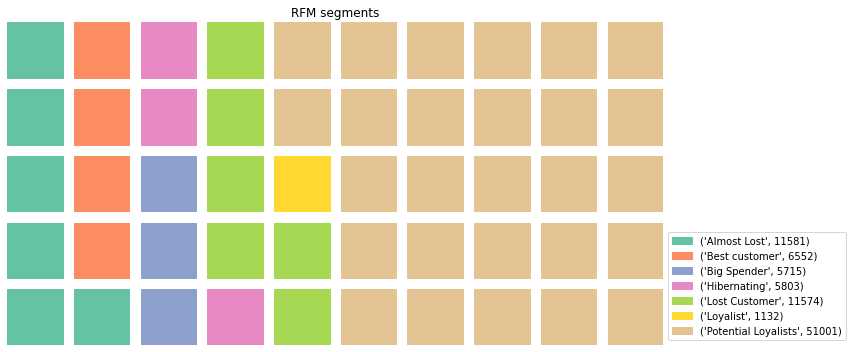

In [ ]:
# Vizualize segment sizes with the waffe chart
plot_waffle_chart_(df_rfm, 'customer_unique_id', 'count', 'RFM segments', 'customer_rfm_segment')

* The biggest RFM segment is the group of Potential loyalists. These are customers that need to targeted with more offers and discounts in order to make them buy more.  
* Some effort needs to be spent to target hibernating customers and customers which are almost lost

In [ ]:
# table
df_tbl_rfm = df_rfm.groupby('customer_rfm_segment').agg(
    Count = ('customer_unique_id', 'count'),
    Recency = ('recency', 'mean'),
    Frequency = ('frequency', 'mean'),
    Monetary = ('total_payment', 'mean'),
    Strategy = ('marketing_approach', 'unique'),
).round(1)
df_tbl_rfm

,Count,Recency,Frequency,Monetary,Strategy
customer_rfm_segment,,,,,
Almost Lost,11581,361.9,1.0,88.8,[Try to win them with limited sales promotions]
Best customer,6552,67.6,1.2,356.4,"[Personalized communication, offer loyalty pro..."
Big Spender,5715,173.9,1.1,346.3,[Make them feel valued and offer quality produ...
Hibernating,5803,447.5,1.0,64.8,[Make great offers with big discounts]
Lost Customer,11574,368.6,1.0,29.0,[Do not spent much effort and money to win them]
Loyalist,1132,291.9,2.1,173.4,[Offer loyalty program]
Potential Loyalists,51001,185.2,1.0,136.7,[Recommend products and offer discounts]


### K-Means clustering

In [ ]:
# create a dataframe using for clustering
df_rfm_kmean = df_rfm[['customer_unique_id','recency', 'frequency', 'total_payment']]
df_rfm_kmean = df_rfm_kmean.set_index('customer_unique_id')
scaler = StandardScaler() 
scaler.fit(df_rfm_kmean) 
df_rfm_norm = scaler.transform(df_rfm_kmean)
df_rfm_norm = pd.DataFrame(data=df_rfm_norm, index=df_rfm_kmean.index, columns=df_rfm_kmean.columns)
df_rfm_norm.head()

,recency,frequency,total_payment
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.828857,-0.159829,-0.054343
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.809198,-0.159829,-0.568964
0000f46a3911fa3c0805444483337064,1.962860,-0.159829,-0.336689
0000f6ccb0745a6a4b88665a16c9f078,0.547341,-0.159829,-0.536093
0004aac84e0df4da2b147fca70cf8255,0.331081,-0.159829,0.177931


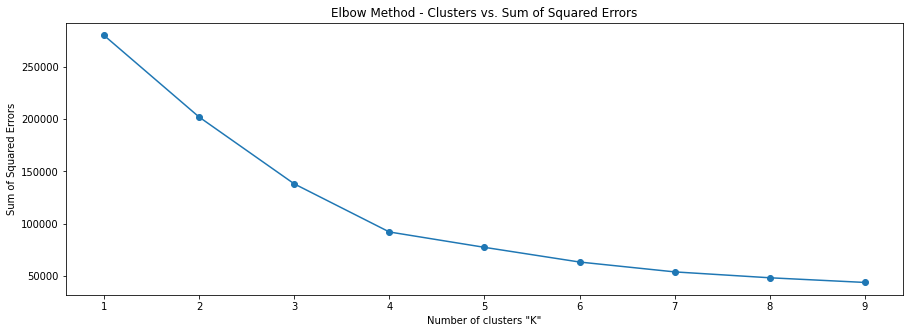

In [ ]:
# find best number of clusters
sse={}
for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_rfm_norm)
  sse[k] = kmeans.inertia_
plt.figure(figsize=(15,5))
plt.plot(list(sse.keys()), list(sse.values()), marker= 'o')
plt.xlabel('Number of clusters "K"')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method - Clusters vs. Sum of Squared Errors');
plt.show()

The Ellbow Method indicates that a cluster number of 4 is a suitable value.

In [ ]:
# how this clustering looks like
k_means = KMeans(n_clusters=4, random_state=42)
k_means.fit(df_rfm_norm)
cluster = k_means.labels_
df_rfm_4 = df_rfm.assign(Cluster=cluster)
df_group_4 = df_rfm_4.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_payment': ['mean', 'count']
  }).round(1)
df_group_4

recency frequency total_payment       
           mean      mean          mean  count
Cluster                                       
0         128.8       1.0         113.4  50832
1         388.2       1.0         114.1  37566
2         238.1       1.0        1142.7   2186
3         220.9       2.1         243.2   2774

In [ ]:
df_rfm_4.head()

,customer_unique_id,recency,frequency,total_payment,avg_payment,quantity,segment,sub_segment,R,F,M,segment_RFM,score_rfm,customer_rfm_segment,marketing_approach,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,129.90,1,active,active_high,4,1,3,413,8,Potential Loyalists,Recommend products and offer discounts,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,18.90,1,active,active_low,4,1,1,411,6,Potential Loyalists,Recommend products and offer discounts,0
2,0000f46a3911fa3c0805444483337064,538,1,69.00,69.00,1,inactive,inactive,1,1,2,112,4,Hibernating,Make great offers with big discounts,1
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,25.99,1,hot,hot_low,2,1,1,211,4,Lost Customer,Do not spent much effort and money to win them,1
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,180.00,1,hot,hot_high,2,1,4,214,7,Potential Loyalists,Recommend products and offer discounts,1


In [ ]:
# save file
df_rfm_4.to_csv(os.path.join(path,'df_rfm_clustering.csv'), encoding='utf-8-sig',index=False)